In [26]:
import pandas as pd
import geopandas as gpd
from sklearn.cluster import DBSCAN
import numpy as np
from scipy.spatial.distance import pdist, squareform, directed_hausdorff # distance de hausdorff calcule la distance entre les polygones non réguliers
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import concurrent.futures # tâches parallèles

In [27]:
# Fonction pour calculer une matrice de distance basée sur les bords des polygones
def calculer_matrice_distance_bords(gdf, poids_spatial=0.7, poids_temporel=0.3, max_dist_spatiale=100, max_dist_temporelle=365):
    """
    Calcule une matrice de distance combinant distance entre bords des polygones et distance temporelle

    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame contenant les polygones de coupes rases avec une colonne 'date'
    poids_spatial : float
        Poids accordé à la composante spatiale (0-1)
    poids_temporel : float
        Poids accordé à la composante temporelle (0-1)
    max_dist_spatiale : float
        Distance spatiale maximale (en mètres) pour normalisation
    max_dist_temporelle : float
        Distance temporelle maximale (en jours) pour normalisation

    Returns:
    --------
    np.array
        Matrice de distance combinée
    """
    n = len(gdf)
    dist_spatiale = np.zeros((n, n))

    # Calcul des distances entre les bords des polygones
    for i in range(n):
        for j in range(i+1, n):
            # Calcul de la distance entre les bords (distance = 0 si les polygones se touchent ou se chevauchent)
            if gdf.iloc[i].geometry.intersects(gdf.iloc[j].geometry):
                dist = 0
            else:
                dist = gdf.iloc[i].geometry.distance(gdf.iloc[j].geometry)

            dist_spatiale[i, j] = dist
            dist_spatiale[j, i] = dist  # La matrice est symétrique

    # Normalisation de la distance spatiale
    dist_spatiale_norm = dist_spatiale / max_dist_spatiale
    dist_spatiale_norm = np.clip(dist_spatiale_norm, 0, 1)

    # Conversion des dates en timestamps pour le calcul des distances temporelles
    dates = pd.to_datetime(gdf['date']).values.astype(np.int64) // 10**9  # Conversion en secondes
    dates_matrix = np.abs(dates[:, np.newaxis] - dates[np.newaxis, :]) / (86400)  # Différence en jours

    # Normalisation de la distance temporelle
    dist_temporelle_norm = dates_matrix / max_dist_temporelle
    dist_temporelle_norm = np.clip(dist_temporelle_norm, 0, 1)

    # Combinaison des distances spatiales et temporelles
    dist_combinee = poids_spatial * dist_spatiale_norm + poids_temporel * dist_temporelle_norm

    return dist_combinee


def calculate_hausdorff_distance_matrix(gdf, geometry_col='geometry', progress_bar=True, n_jobs=-1):
    """
    Calcule la matrice de distance de Hausdorff pour tous les polygones d'un GeoDataFrame
    avec optimisation pour éviter les boucles imbriquées.

    Paramètres:
    -----------
    gdf : geopandas.GeoDataFrame
        Le GeoDataFrame contenant les polygones.
    geometry_col : str, default='geometry'
        Le nom de la colonne contenant les géométries.
    progress_bar : bool, default=True
        Afficher une barre de progression pendant le calcul.
    n_jobs : int, default=-1
        Nombre de processus parallèles (-1 pour utiliser tous les cœurs disponibles).

    Retourne:
    ---------
    pd.DataFrame
        Matrice de distance de Hausdorff entre tous les polygones.
    """
    # Vérifier que toutes les géométries sont des polygones
    non_polygons = gdf[~gdf[geometry_col].apply(lambda g: g.geom_type in ['Polygon', 'MultiPolygon'])]
    if len(non_polygons) > 0:
        print(f"Attention: {len(non_polygons)} géométries ne sont pas des polygones. Elles seront ignorées.")
        gdf = gdf[gdf[geometry_col].apply(lambda g: g.geom_type in ['Polygon', 'MultiPolygon'])]

    # Extraire les géométries
    geometries = gdf[geometry_col].tolist()
    n = len(geometries)

    # Initialiser la matrice de distance
    distances = np.zeros((n, n))

    # Fonction optimisée pour calculer la distance de Hausdorff
    def hausdorff_distance(poly1, poly2):
        # Si les polygones s'intersectent, la distance est 0
        if poly1.intersects(poly2):
            return 0

        # Fonction vectorisée pour calculer la distance de Hausdorff entre polygones simples
        def compute_hausdorff(p1, p2):
            coords1 = np.array(p1.exterior.coords)
            coords2 = np.array(p2.exterior.coords)

            # Calculer les deux directions de la distance de Hausdorff en une seule fois
            h1 = directed_hausdorff(coords1, coords2)[0]
            h2 = directed_hausdorff(coords2, coords1)[0]

            return max(h1, h2)

        # Convertir en listes de polygones
        polys1 = [poly1] if isinstance(poly1, Polygon) else list(poly1.geoms)
        polys2 = [poly2] if isinstance(poly2, Polygon) else list(poly2.geoms)

        # Approche vectorisée pour le calcul des distances
        # Créer une matrice de toutes les paires possibles de polygones
        all_distances = []

        # Cette partie reste une boucle mais simplifiée et plus efficace
        for p1 in polys1:
            for p2 in polys2:
                try:
                    all_distances.append(compute_hausdorff(p1, p2))
                except Exception:
                    # En cas d'erreur, utiliser une grande valeur
                    all_distances.append(np.inf)

        # Retourner la distance minimale
        return min(all_distances) if all_distances else np.inf

    # Fonction pour calculer une rangée de la matrice
    def compute_row(i):
        row = np.zeros(n)
        row[i] = 0  # Distance à soi-même = 0

        for j in range(i+1, n):
            try:
                dist = hausdorff_distance(geometries[i], geometries[j])
                row[j] = dist
            except Exception as e:
                print(f"Erreur lors du calcul de la distance entre les polygones {i} et {j}: {str(e)}")
                row[j] = np.nan

        return i, row

    # Calcul parallélisé de la matrice de distance
    rows_to_compute = range(n)
    if progress_bar:
        rows_to_compute = tqdm(rows_to_compute, desc="Calcul des distances de Hausdorff")

    # Utiliser le parallélisme pour accélérer les calculs
    results = {}
    with concurrent.futures.ProcessPoolExecutor(max_workers=n_jobs) as executor:
        future_to_row = {executor.submit(compute_row, i): i for i in rows_to_compute}
        for future in concurrent.futures.as_completed(future_to_row):
            i, row = future.result()
            results[i] = row

    # Remplir la matrice avec les résultats
    for i, row in results.items():
        distances[i] = row

    # Rendre la matrice symétrique
    for i in range(n):
        for j in range(i+1, n):
            distances[j, i] = distances[i, j]

    # Créer un DataFrame avec les IDs des polygones comme index et colonnes
    if 'id' in gdf.columns:
        ids = gdf['id'].tolist()
    else:
        ids = gdf.index.tolist()

    distance_df = pd.DataFrame(distances, index=ids, columns=ids)

    return distance_df



# Fonction principale pour appliquer DBSCAN
def appliquer_dbscan_coupes_rases(gdf, eps=0.5, min_samples=2, poids_spatial=0.7, poids_temporel=0.3):
    """
    Applique l'algorithme DBSCAN aux données de coupes rases

    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame contenant les polygones de coupes rases avec colonne 'date'
    eps : float
        Paramètre eps de DBSCAN (seuil de distance)
    min_samples : int
        Nombre minimum de points pour former un cluster
    poids_spatial : float
        Poids accordé à la composante spatiale
    poids_temporel : float
        Poids accordé à la composante temporelle

    Returns:
    --------
    GeoDataFrame
        GeoDataFrame original avec une colonne 'cluster' ajoutée
    """
    # Calcul de la matrice de distance combinée utilisant les bords des polygones
    matrice_distances = calculer_matrice_distance_bords(
        gdf, poids_spatial, poids_temporel
    )

    # Application de DBSCAN avec la matrice de distance précalculée
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    clusters = dbscan.fit_predict(matrice_distances)

    # Ajout des résultats au GeoDataFrame
    gdf_results = gdf.copy()
    gdf_results['cluster'] = clusters

    return gdf_results

# Fonction pour fusionner les polygones par cluster
def fusionner_coupes_par_cluster(gdf_clustered):
    """
    Fusionne les polygones appartenant au même cluster

    Parameters:
    -----------
    gdf_clustered : GeoDataFrame
        GeoDataFrame contenant les polygones avec une colonne 'cluster'

    Returns:
    --------
    GeoDataFrame
        GeoDataFrame contenant les polygones fusionnés par cluster
    """
    # On exclut les points considérés comme du bruit (cluster = -1)
    gdf_valid = gdf_clustered[gdf_clustered['cluster'] >= 0].copy()

    # Regroupement par cluster
    dissolved = gdf_valid.dissolve(by='cluster')

    # Calcul de statistiques par cluster
    cluster_stats = gdf_valid.groupby('cluster').agg({
        'date': ['min', 'max', 'count'],
        # Ajoutez d'autres attributs si nécessaire
    })

    # Fusion des statistiques avec la géométrie
    # Problème : les géométries sont dans dissolved, mais les stats dans cluster_stats
    # Solution : Conserver l'index de cluster et faire la jointure correctement
    cluster_stats.columns = ['_'.join(col).strip() for col in cluster_stats.columns.values]

    # Jointure des données statistiques avec les géométries fusionnées
    result = pd.merge(
        cluster_stats,
        dissolved,  # contient uniquement les géométries
        left_index=True,
        right_index=True
    )

    # Conversion en GeoDataFrame
    result = gpd.GeoDataFrame(result, geometry='geometry')

    # Renommage des colonnes pour plus de clarté
    result = result.rename(columns={
        'date_min': 'premiere_coupe',
        'date_max': 'derniere_coupe',
        'date_count': 'nb_coupes'
    })

    # Calcul de la superficie totale
    result['superficie_ha'] = result.geometry.area / 10000  # Conversion en hectares

    return result

# Fonction pour calculer des métriques de qualité du clustering
def evaluer_qualite_clustering(gdf_clustered, gdf_fusionnes):
    """
    Calcule des métriques pour évaluer la qualité du clustering

    Parameters:
    -----------
    gdf_clustered : GeoDataFrame
        GeoDataFrame original avec les attributions de cluster
    gdf_fusionnes : GeoDataFrame
        GeoDataFrame avec les polygones fusionnés par cluster

    Returns:
    --------
    dict
        Dictionnaire contenant différentes métriques de qualité
    """
    # Pourcentage de points considérés comme du bruit
    noise_percentage = (gdf_clustered['cluster'] == -1).mean() * 100

    # Nombre de clusters
    n_clusters = len(gdf_fusionnes)

    # Ratio de réduction (nombre de polygones originaux / nombre de clusters)
    reduction_ratio = len(gdf_clustered) / max(1, n_clusters)

    # Statistiques sur la taille des clusters
    cluster_sizes = gdf_clustered[gdf_clustered['cluster'] >= 0].groupby('cluster').size()
    avg_cluster_size = cluster_sizes.mean()
    max_cluster_size = cluster_sizes.max() if len(cluster_sizes) > 0 else 0

    # Statistiques sur l'étendue temporelle des clusters
    temp_ranges = []
    for idx, row in gdf_fusionnes.iterrows():
        temp_range = (row['derniere_coupe'] - row['premiere_coupe']).days
        temp_ranges.append(temp_range)

    avg_temp_range = np.mean(temp_ranges) if temp_ranges else 0
    max_temp_range = np.max(temp_ranges) if temp_ranges else 0

    # Calcul d'une métrique de compacité spatiale (ratio aire/périmètre)
    compacite = []
    for geom in gdf_fusionnes.geometry:
        if geom.area > 0:
            comp = 4 * np.pi * geom.area / (geom.length ** 2)  # 1 pour un cercle, <1 pour formes moins compactes
            compacite.append(comp)

    avg_compacite = np.mean(compacite) if compacite else 0

    return {
        'nombre_clusters': n_clusters,
        'pourcentage_bruit': noise_percentage,
        'ratio_reduction': reduction_ratio,
        'taille_moyenne_cluster': avg_cluster_size,
        'taille_max_cluster': max_cluster_size,
        'etendue_temporelle_moyenne_jours': avg_temp_range,
        'etendue_temporelle_max_jours': max_temp_range,
        'compacite_moyenne': avg_compacite
    }

# Fonction pour optimiser les paramètres avec une grille plus fine
def optimiser_parametres(gdf, eps_range=np.arange(0.2, 0.7, 0.1),
                        min_samples_range=[2, 3, 4, 5],
                        poids_spatial_range=[0.5, 0.7, 0.9]):
    """
    Recherche les meilleurs paramètres pour DBSCAN

    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame contenant les polygones de coupes rases
    eps_range : array
        Valeurs d'eps à tester
    min_samples_range : list
        Valeurs de min_samples à tester
    poids_spatial_range : list
        Valeurs de poids spatial à tester (poids_temporel = 1 - poids_spatial)

    Returns:
    --------
    pd.DataFrame
        DataFrame contenant les résultats pour chaque combinaison de paramètres
    """
    resultats = []

    for eps in eps_range:
        for min_samples in min_samples_range:
            for poids_spatial in poids_spatial_range:
                poids_temporel = 1 - poids_spatial

                # Application de DBSCAN avec ces paramètres
                gdf_clustered = appliquer_dbscan_coupes_rases(
                    gdf, eps=eps, min_samples=min_samples,
                    poids_spatial=poids_spatial, poids_temporel=poids_temporel
                )

                # Fusion des polygones
                gdf_fusionnes = fusionner_coupes_par_cluster(gdf_clustered)

                # Évaluation de la qualité
                metriques = evaluer_qualite_clustering(gdf_clustered, gdf_fusionnes)

                # Stockage des résultats
                resultats.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'poids_spatial': poids_spatial,
                    'poids_temporel': poids_temporel,
                    **metriques
                })

    return pd.DataFrame(resultats)

# Fonction pour visualiser les résultats
def visualiser_resultats(gdf_original, gdf_clustered, gdf_fusionnes):
    """
    Visualise les résultats du clustering

    Parameters:
    -----------
    gdf_original : GeoDataFrame
        GeoDataFrame original avec les polygones individuels
    gdf_clustered : GeoDataFrame
        GeoDataFrame avec l'attribution des clusters
    gdf_fusionnes : GeoDataFrame
        GeoDataFrame avec les polygones fusionnés par cluster
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Visualisation des polygones originaux
    reference_date = pd.Timestamp('2020-01-01')
    gdf_original['days_since_reference'] = (gdf_original['date'] - reference_date).dt.days

    gdf_original.plot(ax=axes[0], column='days_since_reference', cmap='viridis', legend=True)
    axes[0].set_title('Coupes rases originales')

    # Visualisation des attributions de cluster
    gdf_clustered.plot(ax=axes[1], column='cluster', cmap='tab20', legend=True)
    axes[1].set_title('Attribution des clusters')

    # Visualisation des polygones fusionnés
    gdf_fusionnes.plot(ax=axes[2], column='nb_coupes', cmap='plasma', legend=True)
    axes[2].set_title('Clusters de coupes rases fusionnés')

    plt.tight_layout()
    plt.show()


Métriques finales:
nombre_clusters: 4.00
pourcentage_bruit: 10.00
ratio_reduction: 5.00
taille_moyenne_cluster: 4.50
taille_max_cluster: 5.00
etendue_temporelle_moyenne_jours: 205.00
etendue_temporelle_max_jours: 580.00
compacite_moyenne: 0.55


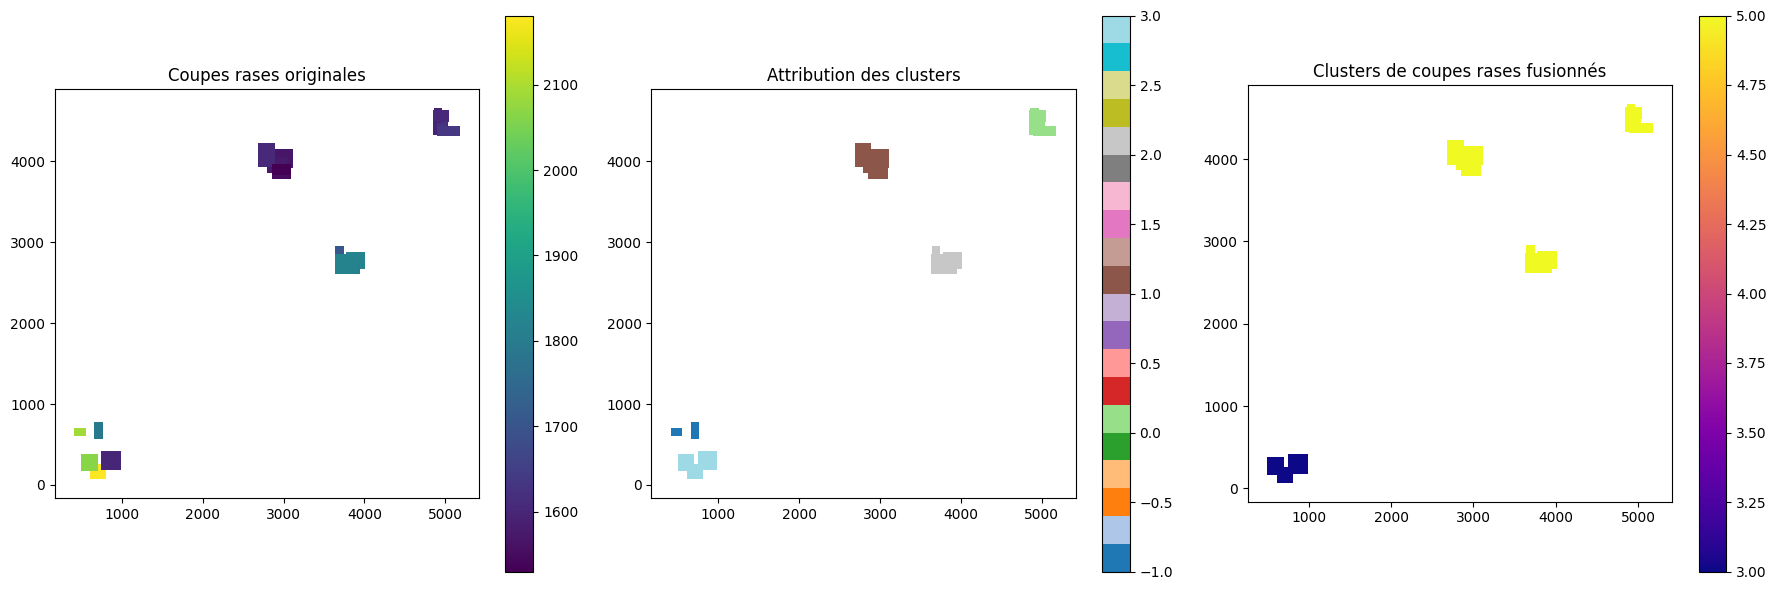

In [28]:
### Exemple sur un jeu de paramètres
eps = 0.5 # unité de distance pour les clusters. Ici c'est une unité spatio-temporelle
min_samples = 2 # au moins 2 polygones pour considérer que c'est un cluster de polygones
poids_spatial = 0.5 # la distance aussi importante que le temps
poids_temporel = 0.5

### Création d'un jeu de test
from shapely.geometry import Polygon
import random

geometries = []
dates = []

# Générer 3 groupes de polygones proches avec des formes variées
for group in range(3):
    center_x = random.uniform(0, 5000)
    center_y = random.uniform(0, 5000)
    base_date = datetime(2024, 1, 1) + pd.Timedelta(days=random.randint(0, 365))

    for i in range(5):  # 5 polygones par groupe
        # Polygone légèrement décalé du centre avec forme variable
        offset_x = random.uniform(-100, 100)
        offset_y = random.uniform(-100, 100)
        width = random.uniform(100, 300)
        height = random.uniform(100, 300)

        # Création d'un polygone avec forme variable
        poly = Polygon([
            (center_x + offset_x, center_y + offset_y),
            (center_x + offset_x + width, center_y + offset_y),
            (center_x + offset_x + width, center_y + offset_y + height),
            (center_x + offset_x, center_y + offset_y + height)
        ])

        geometries.append(poly)

        # Date légèrement décalée
        date_offset = random.randint(0, 120)  # Jusqu'à 4 mois de différence
        dates.append(base_date + pd.Timedelta(days=date_offset))

# Ajouter quelques polygones isolés
for i in range(5):
    x = random.uniform(0, 1000)
    y = random.uniform(0, 1000)
    width = random.uniform(100, 300)
    height = random.uniform(100, 300)

    poly = Polygon([
        (x, y),
        (x + width, y),
        (x + width, y + height),
        (x, y + height)
    ])
    geometries.append(poly)
    dates.append(datetime(2024, 1, 1) + pd.Timedelta(days=random.randint(0, 730)))

# Créer le GeoDataFrame
gdf = gpd.GeoDataFrame({
    'geometry': geometries,
    'date': dates
})


# Définir une projection (important pour les calculs de distance)
gdf.crs = "EPSG:2154"  # Lambert 93 (France)

### application de l'algorithme de DBSCAN
gdf_clustered = appliquer_dbscan_coupes_rases(gdf, eps, min_samples, poids_spatial, poids_temporel)

### Fusion des polygones par cluster
gdf_fusionnes = fusionner_coupes_par_cluster(gdf_clustered)

### Évaluation finale
metriques_finales = evaluer_qualite_clustering(gdf_clustered, gdf_fusionnes)
print("\nMétriques finales:")
for k, v in metriques_finales.items():
    print(f"{k}: {v:.2f}")

### Visualisation des résultats
visualiser_resultats(gdf, gdf_clustered, gdf_fusionnes)


Optimisation des paramètres en cours...

Meilleures combinaisons de paramètres:
    eps  min_samples  poids_spatial  poids_temporel  nombre_clusters  \
51  0.6            3            0.5             0.5                2   
48  0.6            2            0.5             0.5                2   
57  0.6            5            0.5             0.5                2   
54  0.6            4            0.5             0.5                2   
27  0.4            3            0.5             0.5                3   

    pourcentage_bruit  ratio_reduction  taille_moyenne_cluster  \
51                5.0        10.000000                9.500000   
48                5.0        10.000000                9.500000   
57                5.0        10.000000                9.500000   
54                5.0        10.000000                9.500000   
27               45.0         6.666667                3.666667   

    taille_max_cluster  etendue_temporelle_moyenne_jours  \
51                  13        

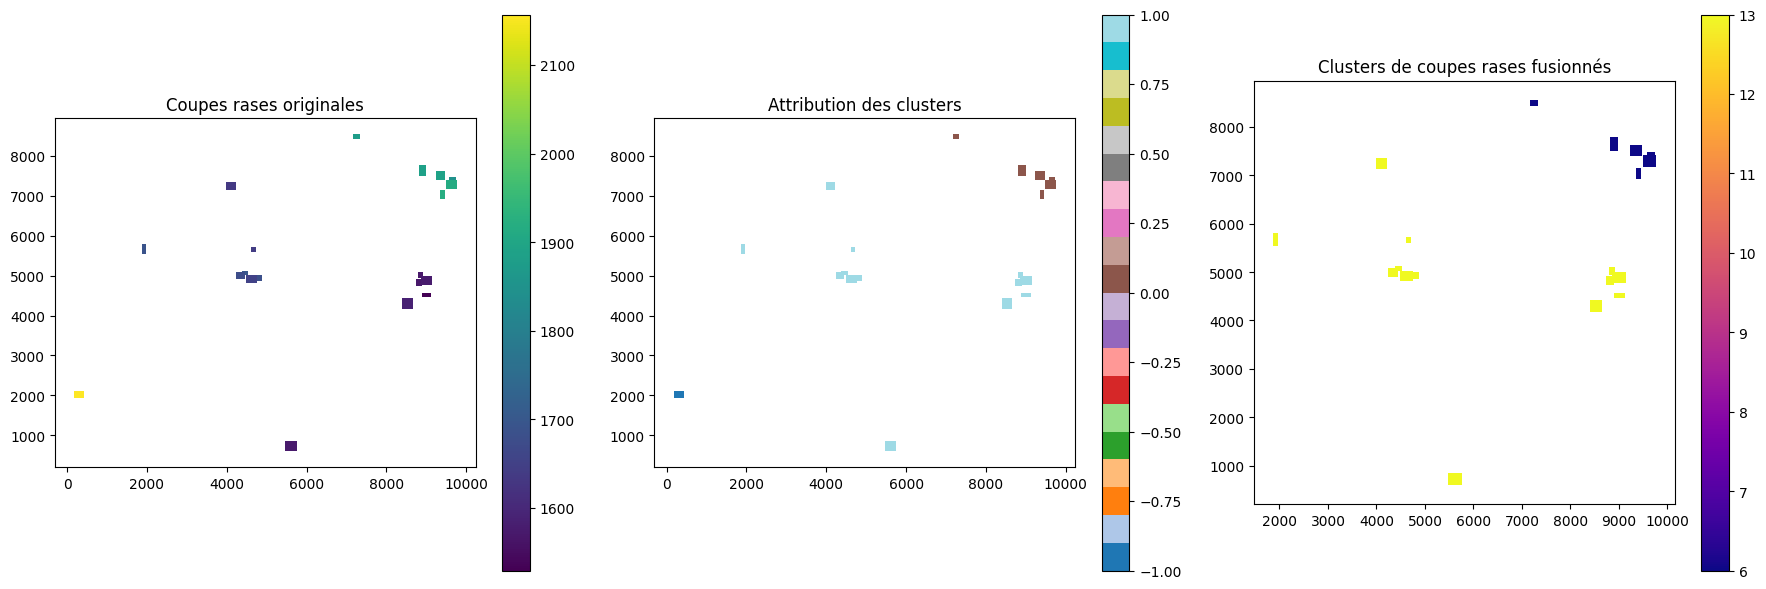

In [20]:
# Exemple d'utilisation complet
  # Chargement des données (exemple)
  # gdf = gpd.read_file("chemin/vers/coupes_rases.shp")

# Pour un exemple simple, créons des données synthétiques
from shapely.geometry import Polygon
import random

# Création de données synthétiques
geometries = []
dates = []

# Générer 3 groupes de polygones proches avec des formes variées
for group in range(3):
    center_x = random.uniform(0, 10000)
    center_y = random.uniform(0, 10000)
    base_date = datetime(2024, 1, 1) + pd.Timedelta(days=random.randint(0, 365))

    for i in range(5):  # 5 polygones par groupe
        # Polygone légèrement décalé du centre avec forme variable
        offset_x = random.uniform(-500, 500)
        offset_y = random.uniform(-500, 500)
        width = random.uniform(100, 300)
        height = random.uniform(100, 300)

        # Création d'un polygone avec forme variable
        poly = Polygon([
            (center_x + offset_x, center_y + offset_y),
            (center_x + offset_x + width, center_y + offset_y),
            (center_x + offset_x + width, center_y + offset_y + height),
            (center_x + offset_x, center_y + offset_y + height)
        ])

        geometries.append(poly)

        # Date légèrement décalée
        date_offset = random.randint(0, 120)  # Jusqu'à 4 mois de différence
        dates.append(base_date + pd.Timedelta(days=date_offset))

# Ajouter quelques polygones isolés
for i in range(5):
    x = random.uniform(0, 10000)
    y = random.uniform(0, 10000)
    width = random.uniform(100, 300)
    height = random.uniform(100, 300)

    poly = Polygon([
        (x, y),
        (x + width, y),
        (x + width, y + height),
        (x, y + height)
    ])
    geometries.append(poly)
    dates.append(datetime(2024, 1, 1) + pd.Timedelta(days=random.randint(0, 730)))

# Créer le GeoDataFrame
gdf = gpd.GeoDataFrame({
    'geometry': geometries,
    'date': dates
})


# Définir une projection (important pour les calculs de distance)
gdf.crs = "EPSG:2154"  # Lambert 93 (France)

# Optimisation des paramètres
print("Optimisation des paramètres en cours...")
params_df = optimiser_parametres(gdf)

# Afficher les 5 meilleures combinaisons de paramètres
print("\nMeilleures combinaisons de paramètres:")
# Tri selon un score composite (exemple)
params_df['score_composite'] = (
    params_df['nombre_clusters'] * 0.4 +
    (100 - params_df['pourcentage_bruit']) * 0.3 +
    params_df['compacite_moyenne'] * 0.3
)
best_params = params_df.sort_values('score_composite', ascending=False).head(5)
print(best_params)

# Sélection des meilleurs paramètres
best_row = best_params.iloc[0]
best_eps = best_row['eps']
best_min_samples = int(best_row['min_samples'])
best_poids_spatial = best_row['poids_spatial']
best_poids_temporel = best_row['poids_temporel']

print(f"\nMeilleurs paramètres sélectionnés:")
print(f"eps = {best_eps}, min_samples = {best_min_samples}")
print(f"poids_spatial = {best_poids_spatial}, poids_temporel = {best_poids_temporel}")

# Application de DBSCAN avec les meilleurs paramètres
gdf_clustered = appliquer_dbscan_coupes_rases(
    gdf, eps=best_eps, min_samples=best_min_samples,
    poids_spatial=best_poids_spatial, poids_temporel=best_poids_temporel
)

# Fusion des polygones par cluster
gdf_fusionnes = fusionner_coupes_par_cluster(gdf_clustered)

# Évaluation finale
metriques_finales = evaluer_qualite_clustering(gdf_clustered, gdf_fusionnes)
print("\nMétriques finales:")
for k, v in metriques_finales.items():
    print(f"{k}: {v:.2f}")

# Visualisation des résultats
visualiser_resultats(gdf, gdf_clustered, gdf_fusionnes)

# Sauvegarde des résultats (décommentez pour utiliser)
# gdf_fusionnes.to_file("resultats_clusters.shp")
# gdf_clustered.to_file("resultats_attribution_clusters.shp")